In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import functional
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader,random_split
import numpy as np
import matplotlib.pyplot as plt

In [48]:
if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device=torch.device('cuda')
else:
    print('CUDA is not available.  Training on CPU ...')
    device=torch.device('cpu')

CUDA is available!  Training on GPU ...


In [49]:
path='../input/100-bird-species/'
num_workers = 4
batch_size = 40
valid_size = 0.2
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(path+'train', transform=train_transform)
test_data = datasets.ImageFolder(path+'test', transform=test_transform)
val_data = datasets.ImageFolder(path+'valid', transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if sys.path[0] == '':


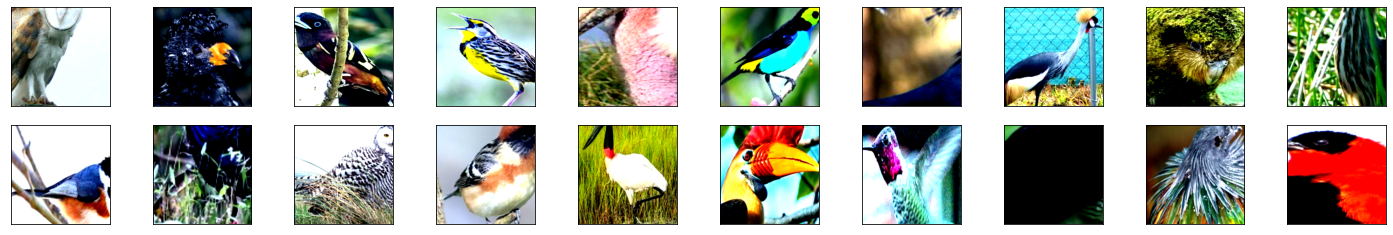

In [50]:
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    # ax.set_title(classes[labels[idx]])

In [51]:
class alex_net(nn.Module):
    def __init__(self):
        super(alex_net,self).__init__()
        self.C1=nn.Conv2d(3,64,kernel_size=(11,11),stride=4,padding=2)
        self.pool=nn.MaxPool2d(3,2)
        self.C2=nn.Conv2d(64,192,kernel_size=(5,5),padding=2)
        self.C3=nn.Conv2d(192,384,kernel_size=(3,3),padding=1)
        self.C4=nn.Conv2d(384,256,kernel_size=(3,3),padding=1)
        self.C5=nn.Conv2d(256,256,kernel_size=(3,3),padding=1)
        self.fc1=nn.Linear(9216,4096)
        self.fc2=nn.Linear(4096,1024)
        self.fc3=nn.Linear(1024,275)
        self.drop=nn.Dropout(0.5)
        self.softmax=nn.LogSoftmax(dim=1)
    def forward(self,x):
        x=self.pool(F.relu(self.C1(x)))
        x=self.pool(F.relu(self.C2(x)))
        x=F.relu(self.C3(x))
        x=F.relu(self.C4(x))
        x=self.pool(F.relu(self.C5(x)))
        x=x.view(x.shape[0],-1)
        x=self.drop(F.relu(self.fc1(x)))
        x=self.drop(F.relu(self.fc2(x)))
        x=self.fc3(x)
        x=self.softmax(x)
        return x
model=alex_net()
model=model.to(device)
print(model)

alex_net(
  (C1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (C2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (C3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (C5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=275, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [52]:
%pip install torch-summary
from torchsummary import summary
summary=summary(model)

Note: you may need to restart the kernel to use updated packages.
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            23,296
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            307,392
├─Conv2d: 1-4                            663,936
├─Conv2d: 1-5                            884,992
├─Conv2d: 1-6                            590,080
├─Linear: 1-7                            37,752,832
├─Linear: 1-8                            4,195,328
├─Linear: 1-9                            281,875
├─Dropout: 1-10                          --
├─LogSoftmax: 1-11                       --
Total params: 44,699,731
Trainable params: 44,699,731
Non-trainable params: 0


In [53]:
optimizer=optim.Adam(model.parameters(),lr=0.001)
criterion=nn.NLLLoss()

In [54]:
from tqdm.notebook import tqdm
n_epochs = 10

valid_loss_min = np.Inf 
last_loss=None
train_losses, val_losses, train_accuracy ,val_accuracy =[] ,[], [], []
for epoch in tqdm(range(1, n_epochs+1)):
    train_class_correct = list(0. for i in range(275))
    train_class_total = list(0. for i in range(275))
    val_class_correct = list(0. for i in range(275))
    val_class_total = list(0. for i in range(275))
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for image, target in train_loader:
        image, target = image.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*image.size(0)
        
        _, train_pred = torch.max(output, 1)
        train_correct = np.squeeze(train_pred.eq(target.data.view_as(train_pred)))
        for i in range(len(target)):
            label = target.data[i].item()
            # print(label)
            train_class_correct[label] += train_correct[i].item()
            train_class_total[label] += 1
    train_accuracy.append(np.sum(train_class_correct)*100 / np.sum(train_class_total))
    model.eval()
    for image, target in valid_loader:
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        valid_loss += loss.item()*image.size(0)
        _, val_pred = torch.max(output, 1)
        val_correct = np.squeeze(val_pred.eq(target.data.view_as(val_pred)))
        for i in range(len(target)):
            label = target.data[i].item()
            # print(label)
            val_class_correct[label] += val_correct[i].item()
            val_class_total[label] += 1
    val_accuracy.append(np.sum(val_class_correct)*100 / np.sum(val_class_total))
        
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'alex_net.pt')
        valid_loss_min = valid_loss

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 5.611920 	Validation Loss: 5.625954
Validation loss decreased (inf --> 5.625954).  Saving model ...
Epoch: 2 	Training Loss: 5.606416 	Validation Loss: 5.625483
Validation loss decreased (5.625954 --> 5.625483).  Saving model ...
Epoch: 3 	Training Loss: 5.609169 	Validation Loss: 5.624531
Validation loss decreased (5.625483 --> 5.624531).  Saving model ...
Epoch: 4 	Training Loss: 5.604974 	Validation Loss: 5.628367
Epoch: 5 	Training Loss: 5.604709 	Validation Loss: 5.627585
Epoch: 6 	Training Loss: 5.604573 	Validation Loss: 5.629870
Epoch: 7 	Training Loss: 5.604178 	Validation Loss: 5.627806
Epoch: 8 	Training Loss: 5.603911 	Validation Loss: 5.629617
Epoch: 9 	Training Loss: 5.603716 	Validation Loss: 5.629359
Epoch: 10 	Training Loss: 5.603547 	Validation Loss: 5.629213


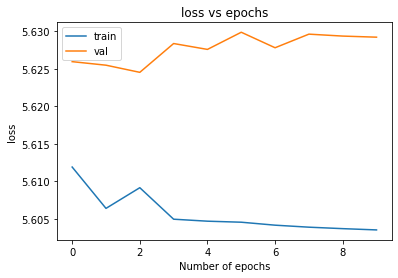

In [55]:
plt.title("loss vs epochs")
plt.xlabel('Number of epochs')
plt.ylabel('loss')
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.legend()
plt.show()

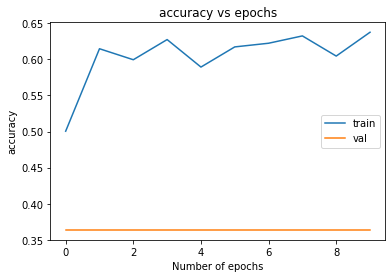

In [56]:
plt.title("accuracy vs epochs")
plt.xlabel('Number of epochs')
plt.ylabel('accuracy')
plt.plot(train_accuracy,label='train')
plt.plot(val_accuracy,label='val')
plt.legend()
plt.show()

In [59]:
model.load_state_dict(torch.load('alex_net.pt'))

<All keys matched successfully>

In [60]:
test_loss = 0.0
class_correct = list(0. for i in range(275))
class_total = list(0. for i in range(275))
model=model.to(device)
classes=list(range(275))
model.eval()

for image, target in test_loader:
    image, target = image.to(device), target.to(device)
    output = model(image)
    loss = criterion(output, target)
    test_loss += loss.item()*image.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i].item()
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.5f}\n'.format(test_loss))

for i in range(275):
    if class_total[i] > 0:
        print('Test Accuracy of %s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 5.62453

Test Accuracy of 0:  0% ( 0/ 5)
Test Accuracy of 1:  0% ( 0/ 5)
Test Accuracy of 2:  0% ( 0/ 5)
Test Accuracy of 3:  0% ( 0/ 5)
Test Accuracy of 4:  0% ( 0/ 5)
Test Accuracy of 5:  0% ( 0/ 5)
Test Accuracy of 6:  0% ( 0/ 5)
Test Accuracy of 7:  0% ( 0/ 5)
Test Accuracy of 8:  0% ( 0/ 5)
Test Accuracy of 9:  0% ( 0/ 5)
Test Accuracy of 10:  0% ( 0/ 5)
Test Accuracy of 11:  0% ( 0/ 5)
Test Accuracy of 12:  0% ( 0/ 5)
Test Accuracy of 13:  0% ( 0/ 5)
Test Accuracy of 14:  0% ( 0/ 5)
Test Accuracy of 15:  0% ( 0/ 5)
Test Accuracy of 16:  0% ( 0/ 5)
Test Accuracy of 17:  0% ( 0/ 5)
Test Accuracy of 18:  0% ( 0/ 5)
Test Accuracy of 19:  0% ( 0/ 5)
Test Accuracy of 20:  0% ( 0/ 5)
Test Accuracy of 21:  0% ( 0/ 5)
Test Accuracy of 22:  0% ( 0/ 5)
Test Accuracy of 23:  0% ( 0/ 5)
Test Accuracy of 24:  0% ( 0/ 5)
Test Accuracy of 25:  0% ( 0/ 5)
Test Accuracy of 26:  0% ( 0/ 5)
Test Accuracy of 27:  0% ( 0/ 5)
Test Accuracy of 28:  0% ( 0/ 5)
Test Accuracy of 29:  0% ( 0/ 5)
